## 뉴스기사 요약해보기

In [1]:
# 라이브러리 임포트
import urllib.request
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
# 데이터 로드
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="data/news_summary_more.csv")
data = pd.read_csv('data/news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))
data.sample(15)

전체 샘플수 : 98401


,headlines,text
597,UK newspaper to pay Melania Trump 'substantial...,British newspaper The Telegraph has apologised...
18272,Ranbir was the first person to tell me I'm a t...,Deepika Padukone has said that Ranbir Kapoor w...
89498,Sharapova's wildcards driven by media coverage...,World number one Andy Murray has claimed that ...
82961,Bharti Singh joins cast of The Kapil Sharma Show,Comedian Bharti Singh has confirmed that she w...
22094,Why was Hyderabad chosen by IKEA for its first...,After Swedish furniture giant IKEA received FD...
76615,Jadeja posts Bollywood dialogue in apparent re...,"All-rounder Ravindra Jadeja, who received one ..."
38351,Robocop named 'Singham' installed in Puducherry,Puducherry LG Kiran Bedi has inaugurated a tou...
91603,3 killed as jetty collapses due to high tide i...,At least three people were killed and several ...
81867,"Boko Haram kidnaps 40 women, slaughters villag...",Nigeria-based terror group Boko Haram has abdu...
48340,Election Commission demands right to deregiste...,The Election Commission of India (ECI) has fil...


#### 데이터 전처리

In [3]:
# 중복 및 결측치 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 (중복 제거 후):', (len(data)))
data.dropna(axis=0, inplace=True)
print('전체 샘플수 (결측치 제거 후):', (len(data)))

전체 샘플수 (중복 제거 후): 98360
전체 샘플수 (결측치 제거 후): 98360


In [4]:
# 텍스트 정규화를 위한 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
# NLTK의 불용어
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\\([^)]*\\)', '', sentence)
    sentence = re.sub('\\"', '', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\\b", "", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

# 전처리 적용
clean_text = [preprocess_sentence(s) for s in data['text']]
clean_headlines = [preprocess_sentence(s, False) for s in data['headlines']]
data['text'] = clean_text
data['headlines'] = clean_headlines
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bychoi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.28
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.30


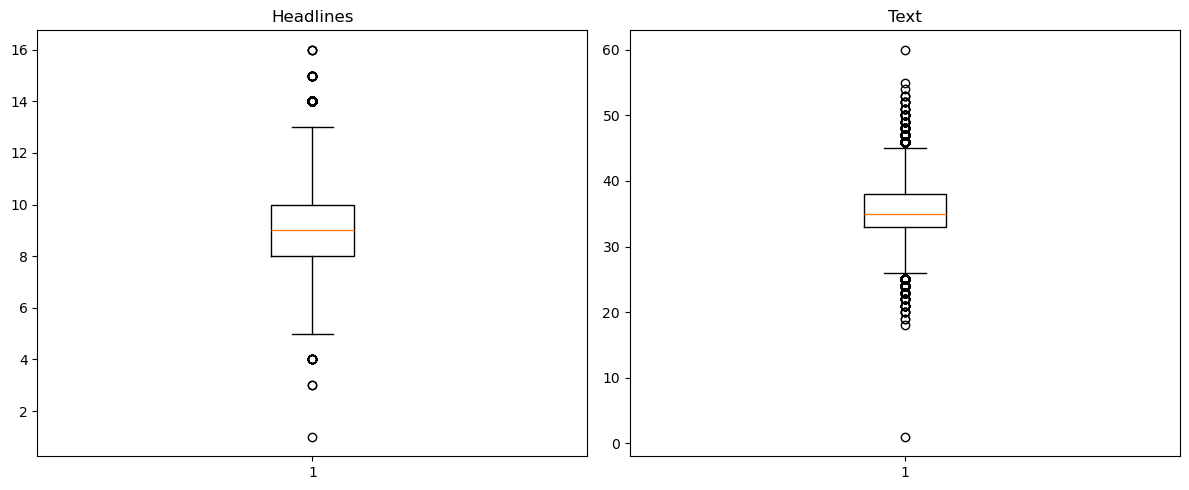

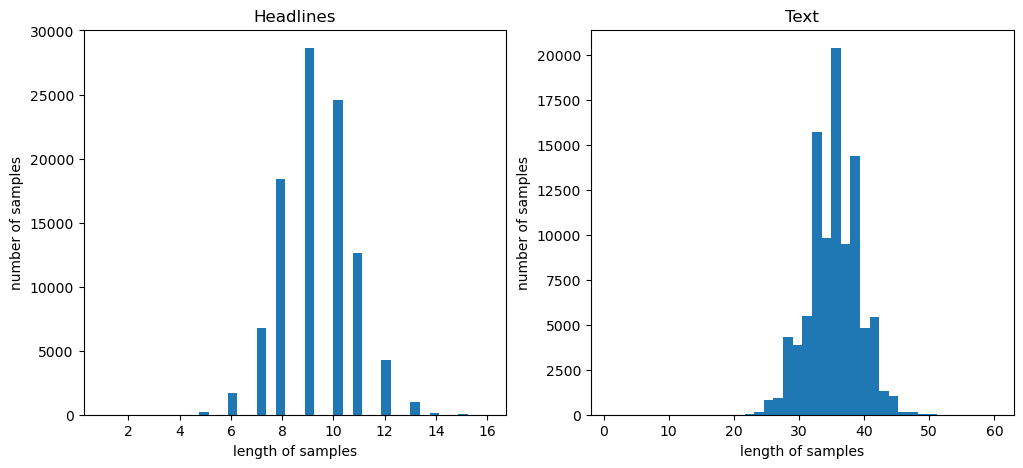

In [5]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {:.2f}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {:.2f}'.format(np.mean(headlines_len)))

# 박스 플롯
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1, 2, 2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

# 히스토그램
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Headlines')
plt.hist(headlines_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.subplot(1, 2, 2)
plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [6]:
# 길이 분포 확인 및 길이 제한
text_max_len = 40
headlines_max_len = 10

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

# 디코더 입력을 위해 시작 토큰과 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

# numpy array로 변환
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

# 훈련 데이터와 테스트 데이터 분리
np.random.seed(42)  # 재현성을 위해 시드 설정
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))

훈련 데이터의 개수 : 58842
테스트 데이터의 개수 : 14710


In [7]:
# 단어 집합 생성 함수
def build_vocab(texts, threshold=2):
    word_counter = Counter()
    for text in texts:
        word_counter.update(text.split())

    vocab = {"<PAD>": 0, "<UNK>": 1, "sostoken": 2, "eostoken": 3}
    for word, count in word_counter.items():
        if count >= threshold:
            vocab[word] = len(vocab)
    return vocab

src_vocab = build_vocab(encoder_input_train)
tar_vocab = build_vocab(np.concatenate([decoder_input_train, decoder_target_train]))
src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)

print('원문 단어 집합의 크기 :', src_vocab_size)
print('요약 단어 집합의 크기 :', tar_vocab_size)

# 텍스트를 시퀀스로 변환하는 함수
def text_to_sequence(texts, vocab):
    return [[vocab.get(word, vocab["<UNK>"]) for word in text.split()] for text in texts]

encoder_input_train = text_to_sequence(encoder_input_train, src_vocab)
decoder_input_train = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train = text_to_sequence(decoder_target_train, tar_vocab)
encoder_input_test = text_to_sequence(encoder_input_test, src_vocab)
decoder_input_test = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test = text_to_sequence(decoder_target_test, tar_vocab)



원문 단어 집합의 크기 : 39694
요약 단어 집합의 크기 : 27222


In [8]:
# 훈련 데이터 패딩
encoder_input_train = pad_sequence([torch.tensor(seq) for seq in encoder_input_train], batch_first=True, padding_value=src_vocab["<PAD>"])
decoder_input_train = pad_sequence([torch.tensor(seq) for seq in decoder_input_train], batch_first=True, padding_value=tar_vocab["<PAD>"])
decoder_target_train = pad_sequence([torch.tensor(seq) for seq in decoder_target_train], batch_first=True, padding_value=tar_vocab["<PAD>"])

# 테스트 데이터 패딩
encoder_input_test = pad_sequence([torch.tensor(seq) for seq in encoder_input_test], batch_first=True, padding_value=src_vocab["<PAD>"])
decoder_target_test = pad_sequence([torch.tensor(seq) for seq in decoder_target_test], batch_first=True, padding_value=tar_vocab["<PAD>"])

print('패딩 후 훈련 데이터 크기:', encoder_input_train.shape)
print('패딩 후 테스트 데이터 크기:', encoder_input_test.shape)


패딩 후 훈련 데이터 크기: torch.Size([58842, 40])
패딩 후 테스트 데이터 크기: torch.Size([14710, 40])


#### 어텐션 메커니즘 사용하기

In [9]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [10]:
# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        # 단어를 벡터로 변환하는 임베딩 레이어, padding_idx를 넣어 패딩 토큰을 무시
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=src_vocab["<PAD>"])
        # LSTM 레이어, bidirectional=True로 설정하여 양방향 LSTM 사용
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        # 양방향 LSTM의 정방향/역방향 hidden state를 합치기 위한 선형 레이어
        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, x):
        # 입력 -> 임베딩 -> LSTM
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        # 양방향 LSTM의 정방향/역방향 hidden state를 합치고 linear 레이어 통과
        hidden = self.fc_hidden(torch.cat((hidden[0:self.lstm.num_layers], hidden[self.lstm.num_layers:self.lstm.num_layers*2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:self.lstm.num_layers], cell[self.lstm.num_layers:self.lstm.num_layers*2]), dim=2))
        return outputs, hidden, cell


In [11]:
# 어텐션 메커니즘
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 3, hidden_size) # hidden_size * 3: hidden state + encoder outputs
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden : 현재 디코더의 hidden state
        # encoder_outputs : 인코더의 모든 hidden state
        src_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # 현재 디코더의 hidden state와 인코더의 모든 hidden state를 합쳐서 어텐션 점수 계산
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        
        # 어텐션 점수 계산
        attention = self.v(energy).squeeze(2)
        
        # 어텐션 점수를 소프트맥스 함수로 정규화
        return F.softmax(attention, dim=1)


In [12]:
# 디코더 
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.attention = Attention(hidden_size)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=tar_vocab["<PAD>"])
        # LSTM 레이어, 입력 크기는 hidden_size * 2 + embedding_dim
        self.lstm = nn.LSTM(hidden_size * 2 + embedding_dim, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size) # 최종 출력 레이어

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        
        # 어텐션 가중치와 컨텍스트 벡터 계산
        a = self.attention(hidden[-1], encoder_outputs).unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        
        # 어텐션 컨텍스트 벡터와 임베딩 벡터를 합쳐서 입력 생성
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        
        # 출력 레이어를 통과하여 최종 예측값 생성
        prediction = self.out(output.squeeze(1))
        return prediction, hidden, cell

In [13]:
# seq2seq 모델
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.shape
        trg_vocab_size = self.decoder.out.out_features
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # 인코더 실행
        encoder_outputs, hidden, cell = self.encoder(src)
        
        # 디코더의 첫 입력은 <sos> 토큰
        input = trg[:, 0]
        
        # 요약 문장의 길이만큼 반복해 단어 생성
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            
            # teacher forcing: 다음 입력으로 실제 타겟 단어를 사용해 학습 안정화
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1) # 가장 높은 확률을 가진 단어 선택
            input = trg[:, t] if teacher_force else top1 # 실제 타겟 단어를 사용하거나 예측된 단어를 사용
        return outputs

In [14]:
# 하이퍼파라미터 설정
embedding_dim = 128
hidden_size = 256
num_layers = 2
dropout = 0.3

encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers, dropout).to(device)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers, dropout).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index=tar_vocab["<PAD>"])

# train 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for _, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# evaluate 함수
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for _, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0) # teacher forcing 비활성화
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# DataLoader 생성
train_dataset = TensorDataset(encoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_target_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# 학습 시작
N_EPOCHS = 30
CLIP = 1
PATIENCE = 3 # 조기 종료를 위한 patience 설정

early_stopping_counter = 0
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch+1}')
            break

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Train Loss: 7.238 | Val. Loss: 7.102
Epoch: 02 | Train Loss: 7.033 | Val. Loss: 7.088
Epoch: 03 | Train Loss: 6.971 | Val. Loss: 7.082
Epoch: 04 | Train Loss: 6.862 | Val. Loss: 6.971
Epoch: 05 | Train Loss: 6.665 | Val. Loss: 6.806
Epoch: 06 | Train Loss: 6.443 | Val. Loss: 6.655
Epoch: 07 | Train Loss: 6.228 | Val. Loss: 6.536
Epoch: 08 | Train Loss: 6.044 | Val. Loss: 6.442
Epoch: 09 | Train Loss: 5.874 | Val. Loss: 6.364
Epoch: 10 | Train Loss: 5.721 | Val. Loss: 6.310
Epoch: 11 | Train Loss: 5.579 | Val. Loss: 6.272
Epoch: 12 | Train Loss: 5.451 | Val. Loss: 6.247
Epoch: 13 | Train Loss: 5.318 | Val. Loss: 6.233
Epoch: 14 | Train Loss: 5.198 | Val. Loss: 6.220
Epoch: 15 | Train Loss: 5.086 | Val. Loss: 6.216
Epoch: 16 | Train Loss: 4.968 | Val. Loss: 6.219
Epoch: 17 | Train Loss: 4.860 | Val. Loss: 6.222
Early stopping at epoch 18


#### 결과 확인

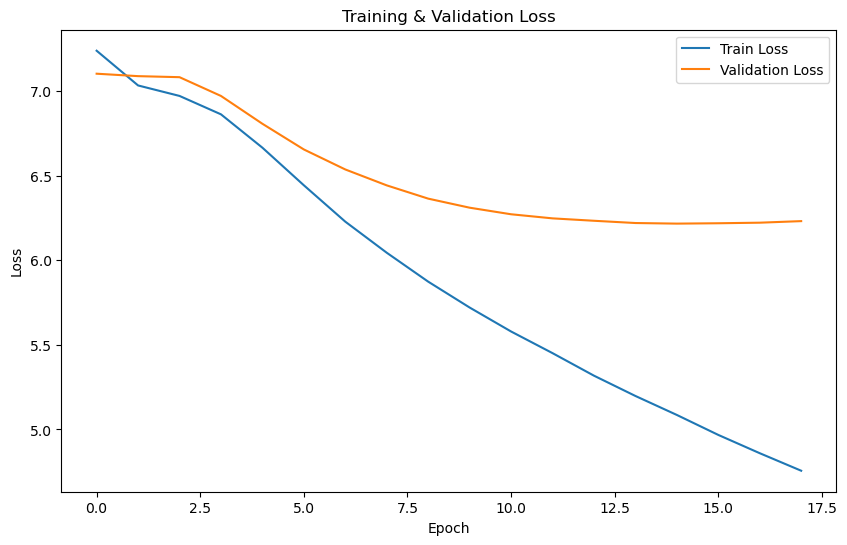

In [15]:
# Loss 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [ ]:
# 가장 성능이 좋았던 모델을 불러오기
model.load_state_dict(torch.load('best-model.pt'))
model = model.to(device)

# 단어 <-> 인덱스 변환 사전 생성
src_index_to_word = {idx: word for word, idx in src_vocab.items()}
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()}

# 추론 함수
def summarize(model, src_tensor, max_len=8):
    model.eval()
    if src_tensor.dim() == 1:
        src_tensor = src_tensor.unsqueeze(0)

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor.to(device))

    trg_indexes = [tar_vocab['sostoken']]

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell, encoder_outputs)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == tar_vocab['eostoken']:
            break

    trg_tokens = [tar_index_to_word.get(i, "<UNK>") for i in trg_indexes]
    return " ".join(trg_tokens[1:-1])

# 테스트 데이터로 결과 확인
for i in range(10):
    # i번째 테스트 데이터 텐서를 가져옴
    src_tensor = encoder_input_test[i]
    trg_tensor = decoder_target_test[i]

    # 출력용 텍스트로 변환 ( .item()을 사용하여 텐서에서 숫자를 추출 )
    src_text = " ".join([src_index_to_word.get(idx.item(), "<UNK>") for idx in src_tensor if idx.item()
!= src_vocab["<PAD>"]])
    trg_text = " ".join([tar_index_to_word.get(idx.item(), "<UNK>") for idx in trg_tensor if idx.item()
not in [tar_vocab["<PAD>"], tar_vocab["sostoken"], tar_vocab["eostoken"]]])

    # 모델로 요약 예측
    predicted_summary = summarize(model, src_tensor)

    print(f"Source: {src_text}")
    print(f"Target: {trg_text}")
    print(f"Predicted: {predicted_summary}\n")

/var/folders/14/wm3n_r1s01jfgw6n8j7pr4740000gn/T/ipykernel_71525/2112316361.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-model.

Source: credit rating agency moody affirmed pakistan rating downgraded outlook stable negative ahead general elections country agency cited factors including heightened external vulnerability risk low foreign exchange reserves changing outlook moody said decision <UNK> rating reflected country potential robust growth
Target: moody downgrades pak ratings to negative ahead of polls
Predicted: releases new new of amid elections in

Source: soviet officer <UNK> <UNK> prevented possible nuclear war us soviet union cold war died aged <UNK> monitoring radar showed us launched nukes russia however <UNK> decided retaliate doubting radar reading later revealed false
Target: soviet officer who averted nuclear war with us dies aged
Predicted: claims us of us of us attack

Source: spicejet saturday cancelled flight ticket shiv sena mp ravindra gaikwad barred several airlines flying assaulted air india staffer last month per reports gaikwad made booking pune ahmedabad flight april earlier air india 

### pretrain모델로 한번 해보기

In [17]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

# 모델을 선택합니다. 't5-small'은 작고 빠르게 테스트해보기 좋은 모델입니다.
MODEL_NAME = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# Hugging Face의 Dataset 형식으로 변환
# (이전에 만들어둔 data DataFrame을 사용합니다)
raw_dataset = Dataset.from_pandas(data)

# T5 모델은 입력에 "summarize: " 라는 prefix를 붙여주는 것이 좋습니다.
prefix = "summarize: "
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=text_max_len, truncation=True)

    # 요약(headlines)을 토큰화합니다.
    labels = tokenizer(text_target=examples["headlines"], max_length=headlines_max_len, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = raw_dataset.map(preprocess_function, batched=True)

/Users/bychoi/miniforge3/envs/my-pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 73552/73552 [00:03<00:00, 21948.70 examples/s]


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
)

# 데이터를 훈련/테스트용으로 다시 분리
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# 데이터 모델 묶기
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# 학습 시작!
trainer.train()

/var/folders/14/wm3n_r1s01jfgw6n8j7pr4740000gn/T/ipykernel_71525/3708450204.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.582600,2.079279
2,2.258800,1.984322
3,2.183200,1.945511


TrainOutput(global_step=11034, training_loss=2.341527244978589, metrics={'train_runtime': 3100.3968, 'train_samples_per_second': 56.936, 'train_steps_per_second': 3.559, 'total_flos': 1866479751659520.0, 'train_loss': 2.341527244978589, 'epoch': 3.0})

In [19]:
# 테스트 데이터 샘플로 결과 확인
for i in range(5):
    original_text = eval_dataset[i]['text']
    real_summary = eval_dataset[i]['headlines']

    # 모델 입력 생성
    inputs = tokenizer(prefix + original_text, return_tensors="pt").to(device)

    # 요약 생성
    summary_ids = model.generate(inputs["input_ids"])
    predicted_summary = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)[0]

    # 결과 출력
    print(f"Source: {original_text}")
    print(f"Target: {real_summary}")
    print(f"Predicted: {predicted_summary}\n")

Source: japan based researchers discovered new species hermit crab shelters solitary corals drags around seafloor researchers describe crabs move shell shell find good fit corals hermit crabs live grow creating stable symbiotic relationship
Target: new found crab species carries its own coral home
Predicted: new species of hermit crab shelters coral

Source: filmmaker vikram bhatt known bold films often horror genre said selling sex bollywood dead said horrex genre movies elements horror sex exist anymore sex horrex data providers killed sex market porn accessible added bhatt
Target: selling sex in bollywood is dead filmmaker vikram bhatt
Predicted: vikram bhatt known for

Source: india first food truck park launched july mumbai shut thursday brihanmumbai municipal corporation official said west ward given permission company run park meanwhile bombay food truck company founder royston misquietta said issue sorted soon adding reopen soon
Target: india st food truck park shut down within

In [27]:
# summa 라이브러리를 사용한 요약
from summa.summarizer import summarize

# 기존에 데이터로 하니까 요약이 안되서 데이터셋 다시 불러옴.
original_data = pd.read_csv('data/news_summary_more.csv', encoding='iso-8859-1')
original_data.dropna(inplace=True) # 결측치만 제거

for i in range(5):
    original_text = original_data['text'].iloc[i]
    real_summary = original_data['headlines'].iloc[i]

    predicted_summary = summarize(original_text, ratio=0.5)  # 요약 비율을 10%로 설정
    
    # 결과 출력
    print(f"Source: {original_text}")
    print(f"Target: {real_summary}")
    print(f"Predicted: {predicted_summary}\n")

Source: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
Target: upGrad learner switches to career in ML & Al with 90% salary hike
Predicted: upGrad's Online Power Learning has powered 3 lakh+ careers.

Source: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Target: Delhi techie wins free food from Swiggy for one year on CRED
Predicted: Users get one CRED coin per rupee 

#### 오늘의 회고
- 데이터 전처리는 확실히 시간이 좀 걸리긴하는 일이지만 잘해야되는 것 같다. 대충하고 양도 안보고 했더니 한 에폭당 시간이 너무 오래걸리고, 결과도 좋지 않아서 시간만 버렸다.
- 결과를 더 올려보고 싶었는데 시간이 좀 부족했던 것 같다. 한번 학습해보는데 1시간 걸려서, 원래 그런 것인가..
- 그렇게 해도 그렇게 썩 결과가 좋진 않아서 gpt의 도움을 받아 프리트레인 모델들은 성능이 어느정도일지 한번 실험해봤다. 확실히 다르긴 다르다.
- summa를 쓴 추출적 요약은 문장구분을 잘 못하는지 전처리된 데이터로는 summary를 전혀 하지 못했고, 원본 데이터로 가져와도 여전히 못하는 데이터가 있었다.
- ratio나 words를 조정하면 되긴하는데 확실히 그래도 내가 한것보단 당장은 더 나아보이긴 하지만 ratio를 늘린건 거의 그냥 복붙같은 느낌이라 얘도 실효성은 없어보인다.